In [1]:
#%reset -f

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
import igraph as ig
import pickle

from numpy import sqrt
from gurobipy import GRB
from pyinstrument import Profiler
from numba import jit

plt.style.use('default')                                    # 使用默认风格
plt.rcParams['figure.facecolor'] = 'white'                  # 将图形的背景颜色设置为白色
plt.rcParams['font.family'] = 'YaHei Consolas Hybrid'       # 字体确认
plt.rcParams['font.size'] = 12                              # 字体大小
plt.rcParams['axes.unicode_minus'] = False                  # 正常显示负号
%matplotlib inline
# matplotlib.use('TkAgg')

## 数据读取与参数设置
def dist(p1, p2):
    return sqrt((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2)

def viaShop(p1, p2, p3):
    return dist(p1, p2) + dist(p2, p3)

def Charge_viaShop(p1, p2, p3, p4):
    return dist(p1, p2) + dist(p2, p3) + dist(p3, p4)

In [48]:
# 读取Excel文件
df1 = pd.read_excel('./q4data.xlsx')
df1['points'] = df1.apply(lambda row: [row['x'], row['y']], axis=1)
df1.drop(columns=['x', 'y'], inplace=True)


for droneMaxPower in [13]:
    # 参数设置
    M = 1 << 16
    userNumber = df1.shape[0]
    shop = [[0.5, 0], [0, 0.5]]
    chargeStation = [0, 0]
    droneSpeed = 60
    # 构建耗时矩阵
    matSize = 4 * userNumber + 2
    distMat_user = np.full((matSize, matSize), float(M))
    distMat_shop = np.full((matSize, matSize), float(M))
    
    ## 计算用户到用户的距离、耗时
    for i in range(4 * userNumber + 1):
        for j in range(1, 4 * userNumber + 2):
            if i >= 1:
                userPoint1 = df1.loc[(i - 1) % userNumber, 'points']
            if j >= 1:
                userPoint2 = df1.loc[(j - 1) % userNumber, 'points']
            if 1 <= j <= userNumber:
                if i == 0:
                    distMat_user[i, j] = viaShop(chargeStation, shop[0], userPoint2)
                    distMat_shop[i, j] = dist(chargeStation, shop[0])
                else:
                    distMat_user[i, j] = viaShop(userPoint1, shop[0], userPoint2) 
                    distMat_shop[i, j] = dist(userPoint1, shop[0])
            elif userNumber + 1 <= j <= 2 * userNumber:
                if i == 0:
                    distMat_user[i, j] = viaShop(chargeStation, shop[1], userPoint2)
                    distMat_shop[i, j] = dist(chargeStation, shop[1])
                else:
                    distMat_user[i, j] = viaShop(userPoint1, shop[1], userPoint2) 
                    distMat_shop[i, j] = dist(userPoint1, shop[1])
            elif 2 * userNumber + 1 <= j <= 3 * userNumber:
                if i == 0:
                    continue
                else:
                    distMat_user[i, j] = Charge_viaShop(userPoint1, chargeStation, shop[0], userPoint2)
                    distMat_shop[i, j] = dist(userPoint1, chargeStation) + dist(chargeStation, shop[0])
            elif 3 * userNumber + 1 <= j <= 4 * userNumber:
                if i == 0:
                    continue
                else:
                    distMat_user[i, j] = Charge_viaShop(userPoint1, chargeStation, shop[1], userPoint2)
                    distMat_shop[i, j] = dist(userPoint1, chargeStation) + dist(chargeStation, shop[1])
            elif j == 4 * userNumber + 1:
                if i == 0:
                    continue
                else:
                    distMat_user[i, j] = dist(userPoint1, chargeStation)     
                    
    timeMat_user = distMat_user / droneSpeed
    timeMat_user[timeMat_user > 1000] = M
    
    timeMat_shop = distMat_shop / droneSpeed
    timeMat_shop[timeMat_shop > 1000] = M
    
    ## 求解
    
    ## 第四问最短时间


    droneNumber = 3
    
    print('---------------------')
    print(' ')
    print(f'{droneNumber}台无人机进行规划，速度{droneSpeed}，电量{droneMaxPower}')
    print(' ')
    print('---------------------')
    
    # 确认分块点集
    Sp = [0]
    Ep = [matSize - 1]
    I = [list(range(1, userNumber + 1)),
         list(range(userNumber + 1, 2 * userNumber + 1)),
         list(range(2 * userNumber + 1, 3 * userNumber + 1)), 
         list(range(3 * userNumber + 1, 4 * userNumber + 1))]
    fullI = I[0] + I[1] + I[2] + I[3]
    U = Sp + fullI + Ep
    
    prob4 = gp.Model('q4无人机调度')
    
    x = prob4.addVars(droneNumber, matSize, matSize, vtype=GRB.BINARY, name='workingPath')
    phi = prob4.addVars(droneNumber, matSize, lb=0, ub=droneMaxPower, vtype=GRB.CONTINUOUS, name='remainPower')
    c = prob4.addVars(droneNumber, matSize, lb=0, ub=1, vtype=GRB.CONTINUOUS, name='begTime')
    s = prob4.addVars(droneNumber, matSize, lb=0, ub=1, vtype=GRB.CONTINUOUS, name='endTime')
    u = prob4.addVars(droneNumber, matSize, vtype=GRB.INTEGER, name='order')
    tMax = prob4.addVar(vtype=GRB.CONTINUOUS, name='timeMax')
    d = prob4.addVars(droneNumber,vtype=GRB.CONTINUOUS, name='dis')
    
    ## 约束
    
    # 对于每一个无人机
    for k in range(droneNumber):
        # 不可能路径约束
        prob4.addConstr(gp.quicksum(x[k, i, j] for i in U for j in Sp) == 0)
        prob4.addConstr(gp.quicksum(x[k, i, j] for i in Sp for j in (I[2] + I[3] + Ep)) == 0)
        prob4.addConstr(gp.quicksum(x[k, i, j] for i in Ep for j in (fullI + Ep)) == 0)
        # 每一个分块矩阵的对角线都为0
        for c1 in range(4):
            for c2 in range(4):
                row_start = I[c1][0]
                col_start = I[c2][0]
                for i in range(userNumber):
                    prob4.addConstr(x[k, row_start + i, col_start + i] == 0)
    
        # 起点终点约束
        prob4.addConstr(gp.quicksum(x[k, 0, j] for j in I[0] + I[1]) == 1)
        prob4.addConstr(gp.quicksum(x[k, i, matSize - 1] for i in fullI) == 1)
        
        # 连续路径约束
        for i in range(1, matSize - 1):
            prob4.addConstr(gp.quicksum(x[k, i, j] for j in U) == 
                            gp.quicksum(x[k, j, i] for j in U))
        
        # MTZ约束
        # 起点
        prob4.addConstr(u[k, 0] == 1)
        # 起点到第一个顾客
        prob4.addConstrs(u[k, i] - u[k, j] + matSize * x[k, i, j] <= matSize - 1 
                         for i in Sp for j in (I[0] + I[1]))
        # 顾客到顾客
        prob4.addConstrs(u[k, i] - u[k, j] + matSize * x[k, i, j] <= matSize - 1 
                         for i in fullI for j in fullI)
        # 顾客到终点
        prob4.addConstrs(u[k, i] - u[k, j] + matSize * x[k, i, j] <= matSize - 1 
                         for i in fullI for j in Ep)
        
        # 起始电量
        prob4.addConstr(phi[k, 0] == droneMaxPower)
        
        # 不充电
        for i in (Sp + fullI):
            for j in (I[0] + I[1]):
                prob4.addConstr(phi[k, j] <= phi[k, i] - distMat_user[i, j] + M * (1 - x[k, i, j]))
                prob4.addConstr(phi[k, j] >= phi[k, i] - distMat_user[i, j] - M * (1 - x[k, i, j]))
        for i in fullI:
            for j in Ep:
                prob4.addConstr(phi[k, j] <= phi[k, i] - distMat_user[i, j] + M * (1 - x[k, i, j]))
                prob4.addConstr(phi[k, j] >= phi[k, i] - distMat_user[i, j] - M * (1 - x[k, i, j]))
        
        # 充电
        for i in fullI:
            for j in (I[2] + I[3]):
                prob4.addConstr(phi[k, j] <= droneMaxPower - distMat_user[0, j % userNumber] + M * (1 - x[k, i, j]))
                prob4.addConstr(phi[k, j] >= droneMaxPower - distMat_user[0, j % userNumber] - M * (1 - x[k, i, j]))
                
        ## 时间约束
        # 初始状态
        prob4.addConstr(s[k, 0] == 0)
        # prob4.addConstr(c[k, 0] == 0)
        
        # 不充电情况
        for i in (Sp + fullI):
            for j in (I[0] + I[1]):
                # 到店时间约束
                # prob4.addConstr(c[k, j] <= s[k, i] + timeMat_shop[i, j] + M * (1 - x[k, i, j]))
                prob4.addConstr(c[k, j] >= s[k, i] + timeMat_shop[i, j] - M * (1 - x[k, i, j]))
                # 送达时间约束
                shop2user = timeMat_user[i, j] - timeMat_shop[i, j]
                prob4.addConstr(s[k, j] <= c[k, j] + shop2user + M * (1 - x[k, i, j]))
                prob4.addConstr(s[k, j] >= c[k, j] + shop2user - M * (1 - x[k, i, j]))
                # 时间窗约束
                prob4.addConstr(c[k, j] >= df1.beg[(j - 1) % userNumber] - M * (1 - x[k, i, j]))
                prob4.addConstr(s[k, j] <= df1.end[(j - 1) % userNumber] + M * (1 + x[k, i, j]))
                
                
        # 充电情况(可以在基地等待)
        for i in fullI:
            for j in (I[2] + I[3]):
                # 到店时间约束
                prob4.addConstr(c[k, j] >= s[k, i] + timeMat_shop[i, j] - M * (1 - x[k, i, j]))
                # 送达时间约束
                shop2user = timeMat_user[i, j] - timeMat_shop[i, j]
                prob4.addConstr(s[k, j] <= c[k, j] + shop2user + M * (1 - x[k, i, j]))
                prob4.addConstr(s[k, j] >= c[k, j] + shop2user - M * (1 - x[k, i, j]))
                # 时间窗约束
                prob4.addConstr(c[k, j] >= df1.beg[(j - 1) % userNumber] - M * (1 - x[k, i, j]))
                prob4.addConstr(s[k, j] <= df1.end[(j - 1) % userNumber] + M * (1 + x[k, i, j]))
        
        # 返回起点的时间约束
        for i in fullI:
            for j in Ep:
                prob4.addConstr(s[k, j] <= s[k, i] + timeMat_user[i, j] + M * (1 - x[k, i, j]))
                prob4.addConstr(s[k, j] >= s[k, i] + timeMat_user[i, j] - M * (1 - x[k, i, j]))
                
        # 每一个无人机的路程
        prob4.addConstr(d[k] == gp.quicksum(x[k, i, j] * distMat_user[i, j] for i in U for j in U))
            
    
    # 更改顾客服务约束
    for i in range(1, userNumber + 1):
        pos1 = i
        pos2 = i + userNumber
        pos3 = i + 2 * userNumber
        pos4 = i + 3 * userNumber
        prob4.addConstr(gp.quicksum(x[k, pos1, j] + x[k, pos2, j] + x[k, pos3, j] + x[k, pos4, j]
                                    for j in U for k in range(droneNumber)) == 1)
    
    # 最大耗时约束
    prob4.addConstrs(tMax >= s[k, matSize - 1] for k in range(droneNumber))
    
    ## 目标函数
    prob4.setObjective(tMax)
    # prob4.write(f'./q4Model/{droneNumber}.lp')
    
    prob4.Params.NoRelHeurTime = 350
    prob4.Params.TimeLimit = 350
    prob4.optimize()
    
    

---------------------
 
3台无人机进行规划，速度60，电量13
 
---------------------
Set parameter NoRelHeurTime to value 350
Set parameter TimeLimit to value 350
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 157010 rows, 21160 columns and 489162 nonzeros
Model fingerprint: 0x06827ee5
Variable types: 742 continuous, 20418 integer (20172 binary)
Coefficient statistics:
  Matrix range     [7e-01, 7e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+01]
  RHS range        [1e+00, 1e+05]
Presolve removed 57813 rows and 2529 columns
Presolve time: 2.37s
Presolved: 99197 rows, 18631 columns, 363834 nonzeros
Variable types: 709 continuous, 17922 integer (17682 binary)
Starting NoRel heuristic
Found phase-1 solution: relaxation 4.758
Found phase-1 solution: relaxation 4.73724
Found phase-1 solution: 

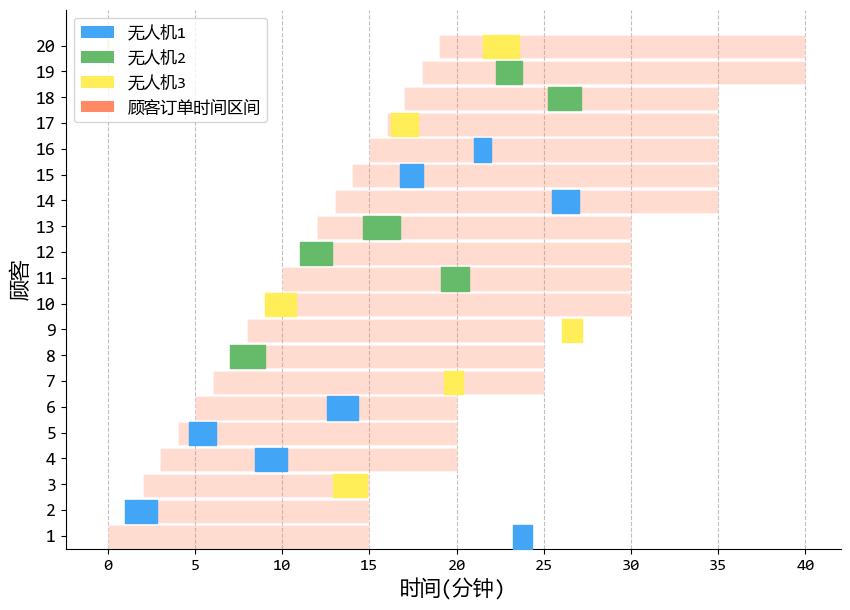

In [49]:
## 甘特图检验

def find_cycle_points(A, start_point):
    # 记录已访问的节点
    visited = set()
    # 存储结果的列表
    cycle_points = []

    # 深度优先搜索
    def dfs(node):
        visited.add(node)
        cycle_points.append(node)

        for next_node in range(len(A[node])):
            if next_node not in visited and A[node][next_node] > 0.5:
                dfs(next_node)

    # 从起点开始搜索
    dfs(start_point)

    return cycle_points

def q4Gantt_draw(df, paths, pickup_time, delivery_time):
    user_number = len(df)
    drone_color = ['#42A5F5', '#66BB6A', '#FFEE58', '#8D6E63','#78909C']
    user_color = '#FF8A65'
    fig, ax = plt.subplots(figsize=(10, 7))
    for i in range(len(paths)):
        ax.bar(0, 0, color=drone_color[i], label=f'无人机{i + 1}')
    ax.bar(0, 0, color=user_color, label='顾客订单时间区间')
    ax.legend(loc='upper left')
    ax.grid(ls='--',alpha=0.8, axis='x')
    # 绘制每一个无人机服务顾客的区间
    for k, path in enumerate(paths):
        for i in range(len(path) - 1):
            user_pos = (path[i] - 1) % user_number
            ax.broken_barh([(pickup_time[k, path[i]], delivery_time[k, path[i]])], (user_pos*10, 9), 
                           facecolors=drone_color[k], edgecolor=drone_color[k],zorder=3)
    
    # 绘制每一个顾客的下单时间和需送达区间
    for i in range(user_number):
        beg_time = df.loc[i, 'beg'] * 60
        end_time = df.loc[i, 'end'] * 60
        ax.broken_barh([(beg_time, end_time - beg_time)], (i*10, 9), 
                facecolors=user_color, edgecolor='white', alpha = 0.3, zorder=2)
        
    # 设置图形显示属性
    y_labels = ['{}'.format(i + 1) for i in range(user_number)]
    ax.set_xlabel('时间(分钟)', fontsize=15)
    ax.set_ylabel('顾客', fontsize=15)
    ax.set_yticks([i * 10 + 5 for i in range(user_number)])
    ax.set_yticklabels(y_labels, fontsize=13)  # 根据实际机器的名称进行调整

    # 隐藏顶部和右侧的边框
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # # 调整甘特图条形颜色的透明度
    # for collection in ax.collections:
    #     collection.set_alpha(0.9)

    plt.savefig('q4顾客服务甘特图.svg', format='svg')

xMat = np.zeros((droneNumber, matSize, matSize))
pickupTime = np.zeros((droneNumber, matSize))
deliveryTime = np.zeros((droneNumber, matSize))
drone_dist = np.zeros((droneNumber, ))
Paths = []
for k in range(droneNumber):
    for i in range(matSize):
        pickupTime[k, i] = c[k, i].x
        deliveryTime[k, i] = s[k, i].x - c[k, i].x
        drone_dist[k] = d[k].x
        for j in range(matSize):
            xMat[k, i, j] = x[k, i, j].x
        
    Paths.append(find_cycle_points(xMat[k], 0))

pickupTime = pickupTime * 60
deliveryTime = deliveryTime * 60

q4Gantt_draw(df1, Paths, pickupTime, deliveryTime)

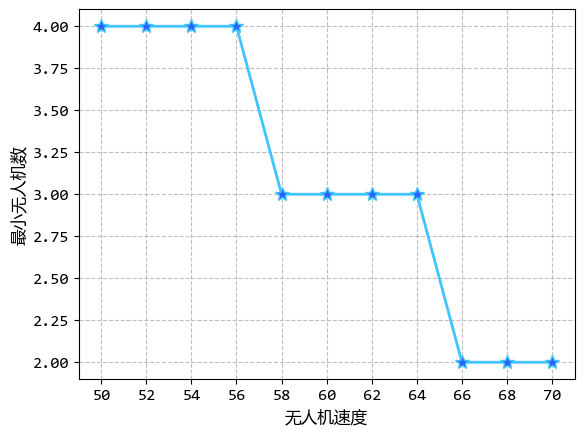

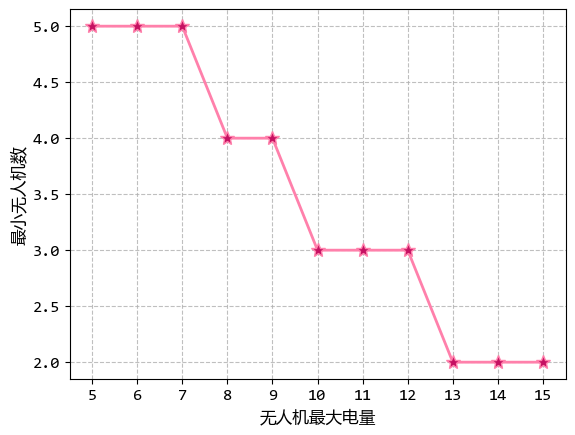

In [57]:
speed_span = np.arange(50, 71, 2)
speed_maxDrone = np.array([4, 4, 4, 4, 3, 3, 3, 3, 2, 2, 2])
power_span = np.arange(5, 16, 1)
power_maxDrone = np.array([5, 5, 5, 4, 4, 3, 3, 3, 2, 2, 2])

plt.figure()
plt.plot(speed_span, speed_maxDrone, marker='*', markersize=10, markerfacecolor='#2962FF', color='#40C4FF', linestyle='-', linewidth=2)
# 添加坐标轴名称
plt.xlabel('无人机速度')
plt.ylabel('最小无人机数')
plt.xticks(speed_span)
plt.grid(ls='--',alpha=0.8)
plt.savefig('q4速度灵敏度分析.svg', format='svg')
plt.figure()

# 绘制第一个列表的折线图
plt.plot(power_span, power_maxDrone, marker='*', markersize=10, markerfacecolor='#C51162', color='#FF80AB', linestyle='-', linewidth=2)
# 添加坐标轴名称
plt.xlabel('无人机最大电量')
plt.ylabel('最小无人机数')
plt.xticks(power_span)
plt.grid(ls='--',alpha=0.8)
plt.savefig('q4电量灵敏度分析.svg', format='svg')
